# Figure 4: SNVs comparison to known sites of phenotypic importance

September 24, 2019

I would like to see whether any of the SNVs we find within-host occur at codon sites that are linked to functional change. To assess this, I used the [Influenza Research Database Sequence Feature Variant Types tool](https://www.fludb.org/brc/influenza_sequenceFeatureVariantTypes_search.spg?method=ShowCleanSearch&decorator=influenza) to download all functional and sequence alteration annotations for each gene. I queried all H5 HA annotations, all N1 NA annotations, and all available annotations for all subtypes for the internal genes. 

In this notebook, I parse that data and use it to annotate my SNV calls. 

In [1]:
import re
import numpy as np
import pandas as pd
import rpy2
from scipy import stats

%load_ext rpy2.ipython

In [2]:
directory = "../data/IRD-functional-SNVs-data/"
SNP_calls = "../data/within-host-variants-1%.tsv"
flugenes = ["PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"]
genes = []
for f in flugenes: 
    gene_file = directory + f + "-known-functional-alteration-sites.tsv"
    genes.append(gene_file)

In [3]:
# write a little function to remove all of the HA1 and HA2 annotations in parantheses 
# using iterative grep 

def remove_HA_annotation(amino_acid_position):
    amino_acid_position = amino_acid_position.replace("\"","")
    amino_acid_position = amino_acid_position.replace("\"","")
    
    searchstr = '(\\([A-z0-9\ ]+\\))'
    for match in re.finditer(searchstr,amino_acid_position):
        amino_acid_position = amino_acid_position.replace(match.groups()[0],"")
        
    return(amino_acid_position)

In [4]:
annotations = {"PB2":{},"PB1":{},"PA":{},"HA":{},"NP":{},"NA":{},"M1":{},"M2":{},"NS1":{},"NEP":{}}

# open annotations and parse into a dictionary 
for g in genes:
    gene = g.replace(directory, "")
    gene = gene.replace("-known-functional-alteration-sites.tsv","")

    with open(g, "r") as infile: 
        for line in infile: 
            sites_to_add = []
            feature = line.split("\t")[1]
            category = line.split("\t")[4]
            amino_acid_position = line.split("\t")[5]
            PMID = line.split("\t")[6]
            comments = line.split("\t")[7].strip()
                    
            # filter out the HA1 annotation in () from the amino acid position
            amino_acid_position = remove_HA_annotation(amino_acid_position)
        
            # if the feature provides a range of amino acid positions with ... and commas
            if ".." in amino_acid_position and "," in amino_acid_position:
                for n in amino_acid_position.split(","):
                    if ".." in n:
                        start = n.split("..")[0]
                        stop = n.split("..")[1]
                        for i in range(int(start), int(stop)+1):
                            sites_to_add.append(int(i))
                    else:
                        sites_to_add.append(n)

            # if the feature provides a range of amino acid positions
            elif ".." in amino_acid_position:
                start = amino_acid_position.split("..")[0]
                stop = amino_acid_position.split("..")[1]
            
                # make annotations for all amino acids in the range of start and stop
                for i in range(int(start), int(stop)+1):
                    sites_to_add.append(int(i))
                     
            # if it is a list of amino acids
            elif "," in amino_acid_position:
                for i in amino_acid_position.split(","):
                    sites_to_add.append(int(i))
       
            # if this is just a single amino acid change     
            else:
                if "Amino Acid Position" not in line:
                    sites_to_add.append(amino_acid_position)            
        
            # add in the sites with their annotations
            for i in sites_to_add: 
                if i not in annotations[gene]:
                    i = int(i)
                    annotations[gene][i] = {}
                    annotations[gene][i]["feature name"] = [feature]
                    annotations[gene][i]["category"] = [category]
                    annotations[gene][i]["PMID"] = [PMID]
                    annotations[gene][i]["comments"] = [comments]
            
                elif i in annotations: 
                    i = int(i)
                    annotations[gene][i]["feature name"].append(feature)
                    annotations[gene][i]["category"].append(category)
                    annotations[gene][i]["PMID"].append(PMID)
                    annotations[gene][i]["comments"].append(comments)
                    
print(annotations)

{'PB2': {736: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 737: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 738: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 739: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_736(4)'], 'category': ['functional'], 'PMID': ['PMID: 1985200, UniProt: P03428 ,'], 'comments': ['This region is required for nuclear localization of PB2']}, 735: {'feature name': ['Influenza A_PB2_nuclear-localization-motif_735(7)'], 'category': ['

In [7]:
"""there were a few ns1 annotations that annotate regions that appear to be at least 
somewhat host specific but do not contain key words. For these, I am just copying the 
entire feature description"""

ns1_traits = ['The flexible tail appears to be unstructured and variable in length. It contains a number of motifs, including CDK/ERK phosphorylation, Crk/CrkL SH3 binding, PDZ ligand and NoLS/NLS2.', 'The NS1 effector domain mediates interactions with several host proteins and may stabilize the N-terminal RNA-binding domain.','Sequence added to Influenza A_NS1_SF29 inhibits NES activity. R148, E152, and E153 are critical for the function of the mask, including in the context of full-length NS1.','The helix-helix ED conformation is conserved in all apo-ED crystal structures, though its physiological relevance is unknown. W187 is essential for ED dimerization in vitro.']

In [8]:
feature_keywords = ["host","pathogenicity","sialic","determinant","adaptation", "species", "tropism","transmissibility","mammal","nuclear-localization","cap-binding"]
description_keywords = ["antiviral","interferon","m7GTP"]

In [54]:
# read in SNP calls file and add annotations to them 
outfilename = directory + "snvs-annotated.tsv"
outfilename2 = directory + "snvs-ns-host-specific-annotated.tsv"

with open(SNP_calls, "r") as infile: 
    for line in infile:
        if "sample" in line:
            with open(outfilename, "w") as outfile:
                outfile.write(line.strip() + "\tfeature_name\tdescription\thost_specific\n")
            with open(outfilename2, "w") as outfile:
                outfile.write(line.strip() + "\tfeature_name\tdescription\thost_specific\n")
        
        if "sample" not in line:
            gene = line.split('\t')[2]
            aa_change = line.split('\t')[6]
            syn_nonsyn = line.split("\t")[7]
            
            if "Stop" in aa_change:
                aa = aa_change.replace("Stop","")
            else:
                aa = aa_change.replace(aa_change[-3:],"")
            aa = aa.replace(aa_change[:3],"")
            aa = int(aa)
            host_specific = ""
            
            if aa in annotations[gene] and aa_change != 'Xaa240Gly':
                feature_name = ",".join(annotations[gene][aa]['feature name'])
                description = ",".join(annotations[gene][aa]['comments'])
                
                """host-specific annotations cann occur in the feature or 
                description of the annotation"""
                for f in feature_keywords: 
                    if f in feature_name: 
                        host_specific = "yes"
                for d in description_keywords: 
                    if d in description: 
                        host_specific = "yes" 
                for n in ns1_traits: 
                    if n in description: 
                        host_specific = "yes"
                        
                if host_specific == "":
                    host_specific = "no"
                                                            
            else:
                feature_name = ""
                description = ""
                host_specific = "no"
                
            if aa_change != 'Xaa240Gly':
                # write annotations to outfile 1
                with open(outfilename, "a") as outfile: 
                    outfile.write(line.strip() + "\t" + feature_name + "\t" + description + "\t"+host_specific+"\n")
                
                # write annotations for all host-specific and nonsynonymous mutations to outfile 2
                if host_specific == "yes" and syn_nonsyn == "nonsynonymous":
                    with open(outfilename2, "a") as outfile: 
                        outfile.write(line.strip() + "\t" + feature_name + "\t" + description + "\t"+host_specific+"\n")

**I then went through and manually checked through this file to make sure that everything was classified appropriately.** 

In [41]:
# now read it back in as a dataframe and plot it 
df = pd.read_table(directory + "snvs-annotated.tsv", sep="\t")
df['species'] = df['sample'].str.contains("duck")
df["species"] = ["duck" if ele  == True else "human" for ele in df["species"]]
df['gene'].fillna('neuraminidase', inplace=True)
df.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,NaN,no,duck
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,Influenza A_NP_RNA-binding-domain_1(187),-N/A-,no,duck
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck


## Check my data for any of the polymerase mutations identified in Welkers et al., H5N1 within-host paper from Indonesia 

I am checking here for both the exact mutation and the site. Neither query turned up anything. My data does not have any of these mutations. 

In [42]:
# query for polymerase mutations identified in Welkers et al.  
Welkers_PB2 = ["Leu183Ser","Gly74Arg","Gln507Arg","Phe323Val","Lys526Arg"]
Welkers_PB1 = ["Pro596Ser","Leu598Pro"]
Welkers_PA = ["Leu336Met"]

# query just the sites 
Welkers_PB2_sites = ["183","74","507","323","526"]
Welkers_PB1_sites = ["596","598"]
Welkers_PA_sites = ["336"]

# generate subsetted dataframes
Welkers_muts_PB2 = df[(df['gene'] == "PB2")]
Welkers_muts_PB2['aa_site'] = Welkers_muts_PB2.coding_region_change.str[3:-3]
Welkers_muts_PB1 = df[(df['gene'] == "PB1")]
Welkers_muts_PB1['aa_site'] = Welkers_muts_PB1.coding_region_change.str[3:-3]
Welkers_muts_PA = df[(df['gene'] == "PA")]
Welkers_muts_PA['aa_site'] = Welkers_muts_PA.coding_region_change.str[3:-3]

# query for the specific change
Welkers_muts_PB2 = Welkers_muts_PB2[Welkers_muts_PB2['coding_region_change'].isin(Welkers_PB2)]
Welkers_muts_PB1 = Welkers_muts_PB1[Welkers_muts_PB1['coding_region_change'].isin(Welkers_PB1)]
Welkers_muts_PA = Welkers_muts_PA[Welkers_muts_PA['coding_region_change'].isin(Welkers_PA)]

# query for the site 
# Welkers_muts_PB2 = Welkers_muts_PB2[Welkers_muts_PB2['aa_site'].isin(Welkers_PB2_sites)]
# Welkers_muts_PB1 = Welkers_muts_PB1[Welkers_muts_PB1['aa_site'].isin(Welkers_PB1_sites)]
# Welkers_muts_PA = Welkers_muts_PA[Welkers_muts_PA['aa_site'].isin(Welkers_PA_sites)]

Welkers_muts_PB2

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


In [43]:
Welkers_muts_PB1

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


In [44]:
Welkers_muts_PA

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,aa_site


### Compare the frequencies of host-specific and non-host-specific SNVs

In [45]:
# perform a t-test to compare whether the frequency of non-host specific SNPs are different than host-specific 
host_spec = df[df['host_specific'] == "yes"]
host_spec = host_spec['frequency']
non_spec = df[df['host_specific'] == "no"]
non_spec = non_spec['frequency']

stats.ttest_ind(host_spec, non_spec, axis=0, equal_var=False)

Ttest_indResult(statistic=1.308385609914008, pvalue=0.19594403211095923)

In [46]:
# output the mean of each 
host_spec_mean = host_spec.mean()
host_spec_std = host_spec.std()
non_spec_mean = non_spec.mean()
non_spec_std = non_spec.std()

host_spec_mean, host_spec_std, non_spec_mean, non_spec_std

(0.07237916666666666,
 0.08095450773548707,
 0.05628585858585858,
 0.05405831314724017)

In [47]:
# perform a t-test to compare whether the frequency of nonsynonymous, non-host specific SNPs are different than 
# nonsynonymous, host-specific 
host_spec = df[df['host_specific'] == "yes"]
host_spec = host_spec[host_spec['synonymous_nonsynonymous'] == 'nonsynonymous']
host_spec = host_spec['frequency']
non_spec = df[df['host_specific'] == "no"]
non_spec = non_spec[non_spec['synonymous_nonsynonymous'] == 'nonsynonymous']
non_spec = non_spec['frequency']

stats.ttest_ind(host_spec, non_spec, axis=0, equal_var=False)

Ttest_indResult(statistic=1.7765981069315302, pvalue=0.08413779518923521)

In [48]:
# output the mean of each 
host_spec_mean = host_spec.mean()
host_spec_std = host_spec.std()
non_spec_mean = non_spec.mean()
non_spec_std = non_spec.std()

host_spec_mean, host_spec_std, non_spec_mean, non_spec_std

(0.0816, 0.08784645316308072, 0.05228645833333334, 0.047303407287517585)

### Test whether having host specific SNVs is associated with days post infection

In [49]:
metadata_df = pd.DataFrame.from_csv("../data/sample-metadata.tsv", sep="\t")
metadata_df.reset_index(inplace=True)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [50]:
df['Sample ID'] = df["sample"].str.title()
host_spec_vs_date = df.merge(metadata_df, on='Sample ID',how='left')
host_spec_vs_date = host_spec_vs_date[host_spec_vs_date['species'] == 'human']
host_spec_vs_date.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,...,host_specific,species,Sample ID,Host,Sample type,Collection,Date,Days_post_symptom_onset,vRNA copies/μl (after vRNA extraction),Clade
40,AA4KNL706F512_A_Cambodia_X0128304_2013_H5,A/Cambodia/X0128304/2013,HA,149,C,T,Thr41Ile,nonsynonymous,5.19%,0.0519,...,no,human,A/Cambodia/X0128304/2013,Human,Throat swab,Event-based surveillance,January 2013,8.0,5.09 x 10^3,1.1.2/2.3.2.1a reassortant
41,AA4KNL706F512_A_Cambodia_X0128304_2013_H5,A/Cambodia/X0128304/2013,HA,163,C,T,Gln46Stop,stop_gained,20.24%,0.2024,...,no,human,A/Cambodia/X0128304/2013,Human,Throat swab,Event-based surveillance,January 2013,8.0,5.09 x 10^3,1.1.2/2.3.2.1a reassortant
42,AA4KNL706F512_A_Cambodia_X0128304_2013_H5,A/Cambodia/X0128304/2013,HA,299,A,G,Glu91Gly,nonsynonymous,6.33%,0.0633,...,yes,human,A/Cambodia/X0128304/2013,Human,Throat swab,Event-based surveillance,January 2013,8.0,5.09 x 10^3,1.1.2/2.3.2.1a reassortant
43,AA4KNL706F512_A_Cambodia_X0128304_2013_H5,A/Cambodia/X0128304/2013,HA,450,T,C,His141His,synonymous,5.69%,0.0569,...,no,human,A/Cambodia/X0128304/2013,Human,Throat swab,Event-based surveillance,January 2013,8.0,5.09 x 10^3,1.1.2/2.3.2.1a reassortant
44,AA4KNL706F512_A_Cambodia_X0128304_2013_H5,A/Cambodia/X0128304/2013,HA,542,A,C,Lys172Thr,nonsynonymous,11.5%,0.1150,...,yes,human,A/Cambodia/X0128304/2013,Human,Throat swab,Event-based surveillance,January 2013,8.0,5.09 x 10^3,1.1.2/2.3.2.1a reassortant


In [51]:
# run Fisher's exact test
import scipy

host_spec_early = len(host_spec_vs_date[(host_spec_vs_date['host_specific'] == 'yes') & (host_spec_vs_date['Days_post_symptom_onset'] <= 8)])
host_spec_late = len(host_spec_vs_date[(host_spec_vs_date['host_specific'] == 'yes') & (host_spec_vs_date['Days_post_symptom_onset'] > 8)])
non_spec_early = len(host_spec_vs_date[(host_spec_vs_date['host_specific'] == 'no') & (host_spec_vs_date['Days_post_symptom_onset'] <= 8)])
non_spec_late = len(host_spec_vs_date[(host_spec_vs_date['host_specific'] == 'no') & (host_spec_vs_date['Days_post_symptom_onset'] > 8)])

table = [[host_spec_early,non_spec_early],[host_spec_late,non_spec_late]]
print(table)

scipy.stats.fisher_exact(table)

[[18, 82], [22, 84]]


(0.8381374722838137, 0.7249907074151232)

## Plot Fig 4 

For this figure, I went through the annotated SNVs file and manually annotated each SNV with a classification regarding it's "type". I classified these types as replication, virulence, interaction with host machinery, and receptor binding. I chose these categories somewhat arbitrarily, just to make it easier to display and group together. The more detailed information about each SNVs function can be found in **Table 3** and **Supplemental table 1**. I also removed 2 SNVs from plotting. These were SNVs in NA taht were annotated because deletions in this region of the NA stalk can alter host specificity. These SNVs were not deletions, and were therefore removed. These were the SNVs Lys58Glu in A/duck/Cambodia/083D1/2011 and Glu47Lys in A/Cambodia/V0417301/2011. 

In [62]:
# read in a dataframe with the type of change annotated 
classified = pd.read_csv(directory + "snvs-ns-host-specific-classified.tsv", header=0, sep = '\t')
classified.columns = ['sampleid','sample','gene','reference_position','reference_allele','variant_allele','coding_region_change','synonymous_nonsynonymous','frequency(%)','frequency','feature_name','description','host_specific','type']
classified.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,type
0,AA4KNL706F512_A_Cambodia_X0128304_2013_PB2,A/Cambodia/X0128304/2013,PB2,1069,A,T,Asn348Tyr,nonsynonymous,6.15%,0.0615,Influenza A_PB2_cap-binding-site_320(164),This fragment is a domain co-crystalized with ...,yes,replication
1,AJ4MBL723F512_A_CAMBODIA_V0401301_2011_PB2,A/CAMBODIA/V0401301/2011,PB2,1202,A,C,Gln392His,nonsynonymous,3.61%,0.0361,Influenza A_PB2_cap-binding-site_320(164),This fragment is a domain co-crystalized with ...,yes,replication
2,AJ4MBL720F513_A_Cambodia_W0112303_2012_PB2,A/Cambodia/W0112303/2012,PB2,1891,G,A,Glu627Lys,nonsynonymous,6.63%,0.0663,Influenza A_PB2_transmissibility_627(1),A/Vietnam/1203/2004 isolate possessing 627Lys ...,yes,replication
3,AJ4MBL720F514_A_Cambodia_X0125302_2013_PB2,A/Cambodia/X0125302/2013,PB2,2022,G,A,Val667Ile,nonsynonymous,2.99%,0.0299,Influenza A_PB2_determinant-of-transmission_66...,The presence of an V667I substitution enhances...,yes,replication
4,AJ4MBL720F513_A_Cambodia_W0112303_2012_PB2,A/Cambodia/W0112303/2012,PB2,2113,A,G,Asn701Asp,nonsynonymous,16.49%,0.1649,Influenza A_PB2_tissue-tropism_701(1),Introduction of Asn701Asp substitution in PB2 ...,yes,replication


In [63]:
non_host_specific = df[df['host_specific'] == 'no']
non_host_specific.head()

,sampleid,sample,gene,reference_position,reference_allele,variant_allele,coding_region_change,synonymous_nonsynonymous,frequency(%),frequency,feature_name,description,host_specific,species,Sample ID
0,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,A/duck/Cambodia/381W11M4/2013,HA,793,G,A,Ala265Thr,nonsynonymous,3.28%,0.0328,NaN,NaN,no,duck,A/Duck/Cambodia/381W11M4/2013
1,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,A/duck/Cambodia/381W11M4/2013,NP,384,A,G,Gln117Arg,nonsynonymous,20.43%,0.2043,Influenza A_NP_RNA-binding-domain_1(187),-N/A-,no,duck,A/Duck/Cambodia/381W11M4/2013
2,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,939,A,G,Ala307Ala,synonymous,4.55%,0.0455,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck,A/Duck/Cambodia/381W11M4/2013
3,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1118,G,A,Arg367Lys,nonsynonymous,19%,0.1900,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck,A/Duck/Cambodia/381W11M4/2013
4,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,A/duck/Cambodia/381W11M4/2013,PA,1608,G,A,Pro530Pro,synonymous,4.38%,0.0438,Influenza A_PA_PB1-binding-region_257(460),The C-terminus of PA interacts with the N-term...,no,duck,A/Duck/Cambodia/381W11M4/2013


In [64]:
# add these typed changes to the non-host specific mutations in non_host_specific
all_snvs_classified = non_host_specific.append(typed)
all_snvs_classified = all_snvs_classified.fillna('no known function')
all_snvs_classified.head()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,Sample ID,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele
0,A/Duck/Cambodia/381W11M4/2013,Ala265Thr,no known function,no known function,0.0328,3.28%,HA,no,G,793,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,duck,nonsynonymous,no known function,A
1,A/Duck/Cambodia/381W11M4/2013,Gln117Arg,-N/A-,Influenza A_NP_RNA-binding-domain_1(187),0.2043,20.43%,NP,no,A,384,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,duck,nonsynonymous,no known function,G
2,A/Duck/Cambodia/381W11M4/2013,Ala307Ala,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0455,4.55%,PA,no,A,939,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,G
3,A/Duck/Cambodia/381W11M4/2013,Arg367Lys,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.1900,19%,PA,no,G,1118,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,nonsynonymous,no known function,A
4,A/Duck/Cambodia/381W11M4/2013,Pro530Pro,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0438,4.38%,PA,no,G,1608,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,A


In [65]:
# add in a species column
all_snvs_classified['species'] = all_snvs_classified['sample'].str.contains("duck", "duck")
all_snvs_classified['species'] = all_snvs_classified['species'].replace(True,"duck")
all_snvs_classified['species'] = all_snvs_classified['species'].replace(False,"human")
all_snvs_classified['species_ns'] = all_snvs_classified['species'] + " " + all_snvs_classified['synonymous_nonsynonymous']
all_snvs_classified.head()

,Sample ID,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele,species_ns
0,A/Duck/Cambodia/381W11M4/2013,Ala265Thr,no known function,no known function,0.0328,3.28%,HA,no,G,793,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_H5,duck,nonsynonymous,no known function,A,duck nonsynonymous
1,A/Duck/Cambodia/381W11M4/2013,Gln117Arg,-N/A-,Influenza A_NP_RNA-binding-domain_1(187),0.2043,20.43%,NP,no,A,384,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_NP,duck,nonsynonymous,no known function,G,duck nonsynonymous
2,A/Duck/Cambodia/381W11M4/2013,Ala307Ala,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0455,4.55%,PA,no,A,939,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,G,duck synonymous
3,A/Duck/Cambodia/381W11M4/2013,Arg367Lys,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.1900,19%,PA,no,G,1118,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,nonsynonymous,no known function,A,duck nonsynonymous
4,A/Duck/Cambodia/381W11M4/2013,Pro530Pro,The C-terminus of PA interacts with the N-term...,Influenza A_PA_PB1-binding-region_257(460),0.0438,4.38%,PA,no,G,1608,A/duck/Cambodia/381W11M4/2013,AJJ9KL706F510_A_duck_Cambodia_381W11M4_2013_PA,duck,synonymous,no known function,A,duck synonymous


In [66]:
# to only color nonsynonymous changes in figure 4, annotate all synonymous changes as no known function
all_snvs_classified['type'][all_snvs_classified.synonymous_nonsynonymous == "synonymous"] = "no known function"
all_snvs_classified.tail()

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Sample ID,coding_region_change,description,feature_name,frequency,frequency(%),gene,host_specific,reference_allele,reference_position,sample,sampleid,species,synonymous_nonsynonymous,type,variant_allele,species_ns
24,no known function,Cys50Tyr,The viruses lacking the palmitoylation site at...,Influenza A_M2_determinant-of-virulence_50(1),0.0203,2.03%,M2,yes,G,861,A/Cambodia/X1030304/2013,AJ4MBL720F516_A_Cambodia_X1030304_2013_MP,human,nonsynonymous,virulence,A,human nonsynonymous
25,no known function,Pro159Leu,Sequence added to Influenza A_NS1_SF29 inhibit...,Influenza A_NS1_NES-mask_148(14),0.0288,2.88%,NS1,yes,C,502,A/Cambodia/X0128304/2013,AA4KNL706F512_A_Cambodia_X0128304_2013_NS,human,nonsynonymous,interaction with host machinery,T,human nonsynonymous
26,no known function,Leu207Pro,The flexible tail appears to be unstructured a...,Influenza A_NS1_flexible-tail_204(27),0.0222,2.22%,NS1,yes,T,646,A/duck/Cambodia/Y0224301/2014,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,duck,nonsynonymous,interaction with host machinery,C,duck nonsynonymous
27,no known function,Pro210Ser,The flexible tail appears to be unstructured a...,Influenza A_NS1_flexible-tail_204(27),0.0255,2.55%,NS1,yes,C,654,A/duck/Cambodia/Y0224301/2014,AJJ9KL707F515_A_duck_Cambodia_Y0224301_2014_NS,duck,nonsynonymous,interaction with host machinery,T,duck nonsynonymous
28,no known function,Glu47Gly,Residues 47 and 51 of NS2 are associated with ...,Influenza A_NS2_determinants-of-virulence_47(2),0.0459,4.59%,NEP,yes,A,609,A/Cambodia/X0207301/2013,AJ4MBL723F514_A_Cambodia_X0207301_2013_NS,human,nonsynonymous,virulence,G,human nonsynonymous


## Plot figure 4

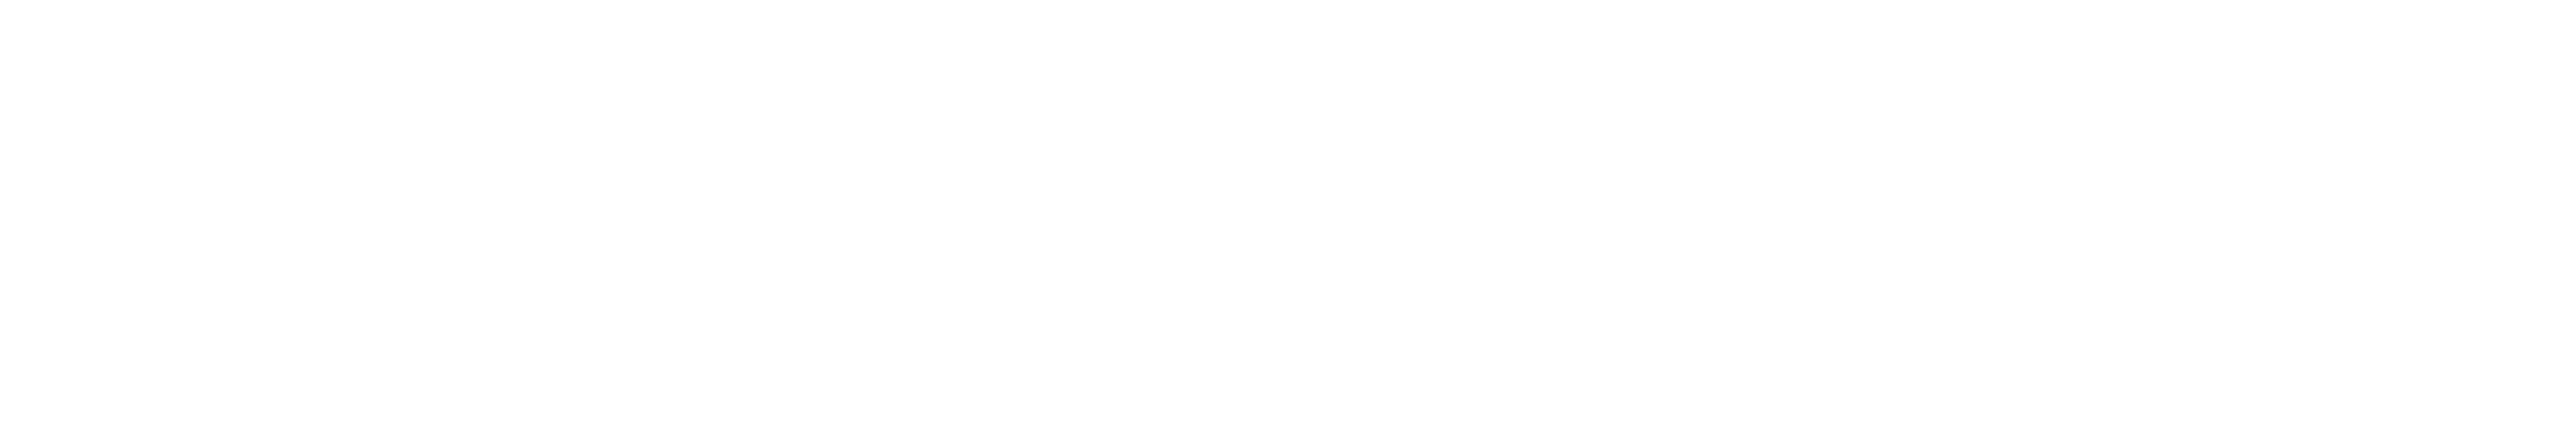

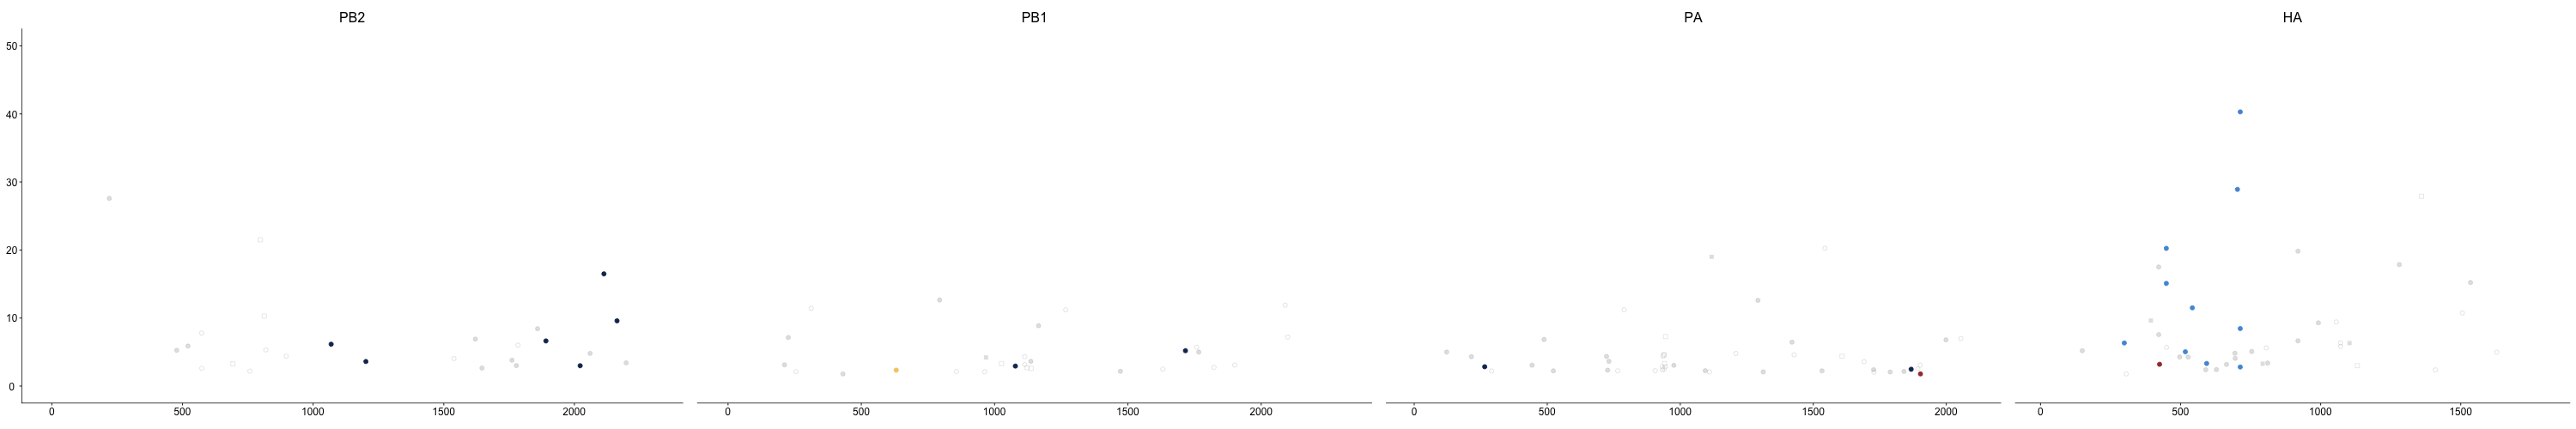

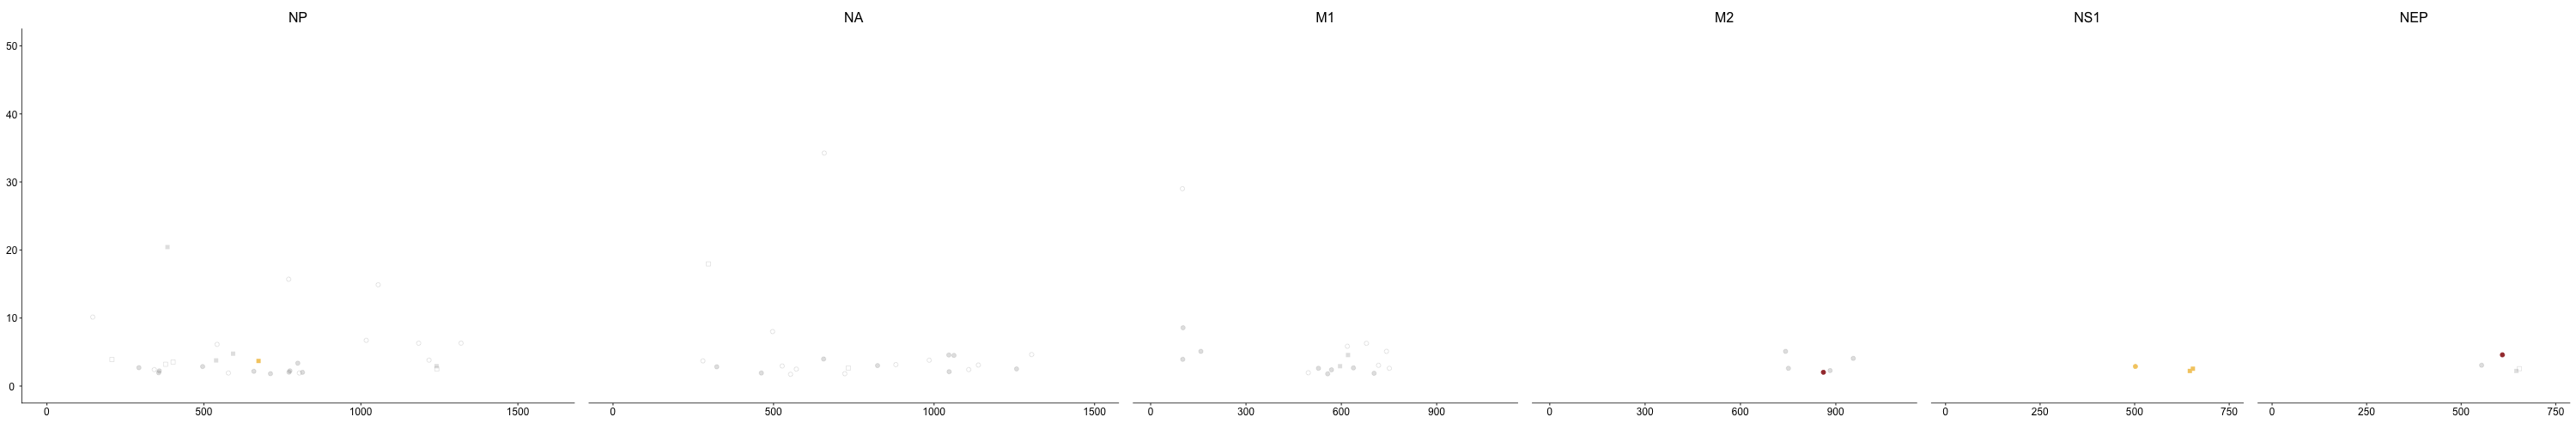

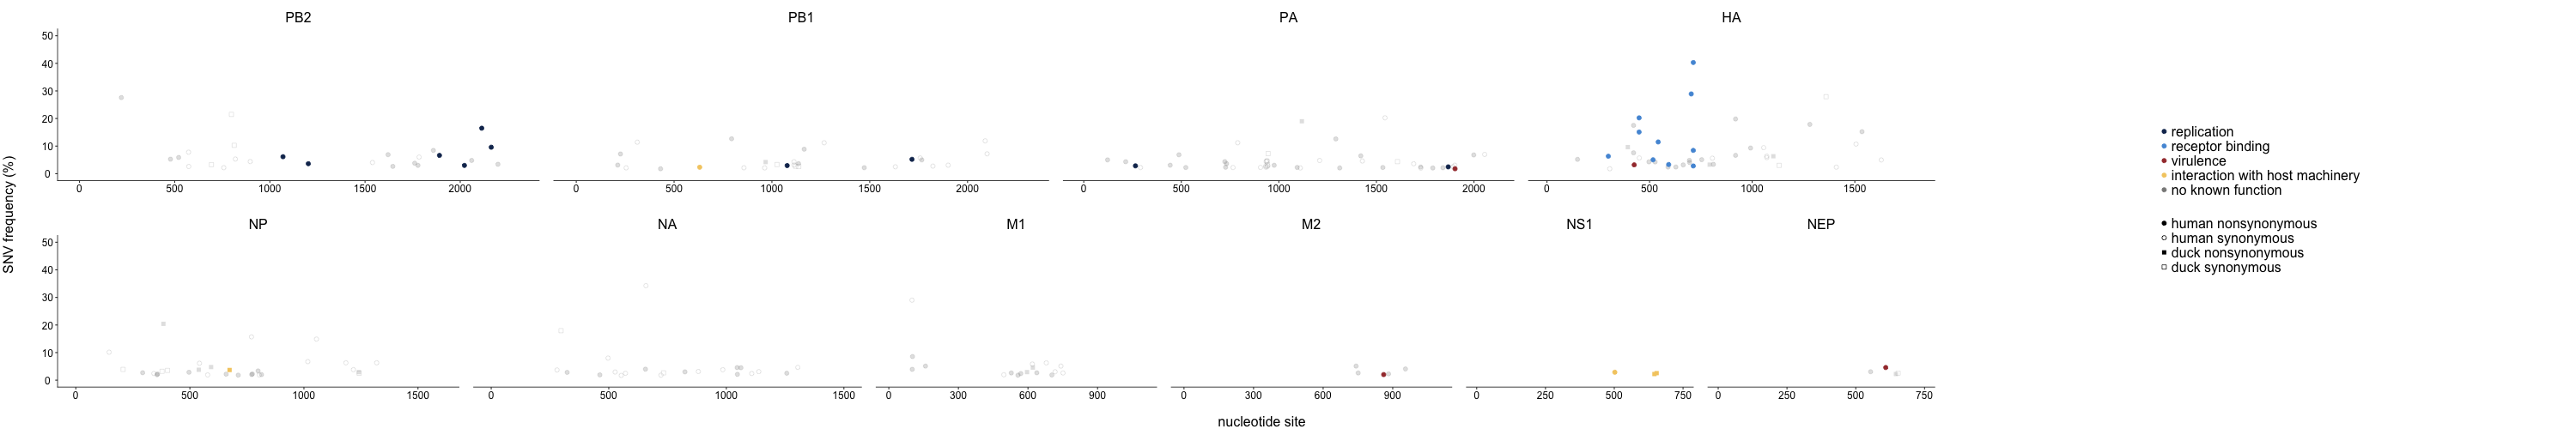

In [68]:
%%R -w 3000 -h 500 -u px -i all_snvs_classified  # this sets the size of the plot...otherwise, it will go off the page"

require(ggplot2)
library(ggplot2)
require(grid)
library(grid)
require(gridExtra)
library(gridExtra)
        
all_snvs_classified$gene = gsub("neuraminidase", "NA", all_snvs_classified$gene)
all_snvs_classified$genef = factor(all_snvs_classified$gene, levels=c("PB2","PB1","PA","HA","NP","NA","M1","M2","NS1","NEP"))
all_snvs_classified$typef = factor(all_snvs_classified$type, levels=c("replication","receptor binding","virulence", "interaction with host machinery","no known function"))
all_snvs_classified$species_nsf = factor(all_snvs_classified$species_ns, levels=c("human nonsynonymous", "human synonymous", "duck nonsynonymous","duck synonymous"))

blank_data <- data.frame(genef = c("PB2","PB2","PB1","PB1","PA","PA","HA","HA","NP","NP","NA","NA","M1","M1","M2","M2","NS1","NS1","NEP","NEP"), x = c(0,2500,0,2500,0,2500,0,1800,0,1600,0,1500,0,1200,0,1200,0,1000,0,1000), y = 0, synonymous_nonsynonymous="nonsynonymous",typef="no known function",species='duck', species_nsf='duck nonsynonymous')

genes = c('PB2','PB1','PA','HA','NP','NA','M1','M2','NS1','NEP')
stops = list('PB2'=2300,'PB1'=2300,'PA'=2100,'HA'=1800,'NP'=1600,'NA'=1500,'M1'=1100,'M2'=1100,'NS1'=750,'NEP'=750)
steps = list('PB2'=500,'PB1'=500,'PA'=500,'HA'=500,'NP'=500,'NA'=500,'M1'=300,'M2'=300,'NS1'=250,'NEP'=250)
plots = list()

for (g in genes)
{
    df = all_snvs_classified[all_snvs_classified$gene == g,]
    stop = stops[[g]]
    step = steps[[g]]
    name = paste(g, "plot",sep = '_')
    
    # set PB2 and NP-specific y-axis aesthetics
    if (g == "PB2"| g == 'NP'){
        y_aesthetics = theme(axis.line.y=element_line(colour="black"))+
        theme(axis.text.y=element_text(hjust=0.5))            
    } else {
        y_aesthetics = theme(axis.line.y=element_blank())+
        theme(axis.ticks.y= element_blank())+
        theme(axis.text.y=element_blank())
    }
        
    p <- ggplot(data=df, aes(x=reference_position, y=frequency*100, color=typef, alpha=typef, shape=species_nsf)) + #, alpha=host_specific
        geom_point(size=2)+                                                  
        geom_blank(data = blank_data, aes(x = x, y = y))+
        theme(panel.grid.major=element_line(colour=NA,size=NA))+
        theme(panel.grid.minor=element_line(colour=NA,size=NA))+
        theme(plot.title=element_text(size=16, hjust=0.5))+
        theme(strip.background = element_rect(colour=NA, fill=NA))+
        theme(plot.margin=unit(c(0.5,0.25,0.5,0.25),"cm"))+    # this sets the plot margins as top, left, bottom, right
        theme(axis.line.x=element_line(colour="black"))+
        theme(strip.text.x=element_text(size=13))+
        theme(axis.title.y=element_blank())+#text(size=16, hjust=0.5, vjust=0.5))+
        theme(axis.title.x=element_blank())+#text(size=16, vjust=0.5))+
        theme(axis.text=element_text(size=12, colour="black"))+
        y_aesthetics+
        scale_color_manual(values=c("replication"="#14325C","receptor binding"="#5398D9","virulence"="#A53A3B", "interaction with host machinery"="#F4CC70","no known function"="#8A8A89"), guide=FALSE)+
        scale_shape_manual(values=c("human nonsynonymous"=19,"human synonymous"=1,"duck nonsynonymous"=15,"duck synonymous"=0), guide=FALSE)+
        scale_alpha_manual(values=c("replication"=1,"receptor binding"=1,"virulence"=1, "interaction with host machinery"=1,"no known function"=0.25), guide=FALSE)+
        theme(legend.text=element_text(size=16))+
        theme(legend.title=element_blank())+
        theme(panel.margin=unit(1, "lines"))+
        theme(panel.background=element_rect(fill=NA, color=NA))+
        theme(legend.key=element_rect(fill=NA))+
        theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
        labs(x="\nnucleotide site",y="SNV frequency\n", title=g)+
        theme(legend.direction = 'horizontal', legend.position = 'right')+
        scale_y_continuous(limits=c(0,50))+
        scale_x_continuous(limits=c(0,stop), breaks=seq(0,stop,step))
    
    plots[[name]] <- p
} 

# add in an extra, blank plot with a legend so that I can plot the legend in a separate panel 
extra <- ggplot(data=all_snvs_classified, aes(x=reference_position, y=frequency, color=typef, shape=species_nsf))+
    geom_point(size=2)+
    theme(legend.text=element_text(size=16))+
    theme(legend.title=element_blank())+
    theme(legend.key=element_rect(fill=NA))+
    theme(legend.key.size=unit(0.6, "cm"))+   # alter this to make legend items further apart
    scale_color_manual(values=c("replication"="#14325C","receptor binding"="#5398D9","virulence"="#A53A3B", "interaction with host machinery"="#F4CC70","no known function"="#8A8A89"), breaks=c("replication","receptor binding","virulence", "interaction with host machinery","no known function"), drop=FALSE)+
    scale_shape_manual(values=c(19,1,15,0), breaks=c("human nonsynonymous", "human synonymous", "duck nonsynonymous","duck synonymous"), drop=FALSE)+
    guides(color = guide_legend(nrow = 5))+
    guides(shape = guide_legend(nrow = 5))

# extract out the legend and then plot just that 
gglegend <- function(x){ 
  tmp <- ggplot_gtable(ggplot_build(x)) 
  leg <- which(sapply(tmp$grobs, function(y) y$name) == "guide-box") 
  tmp$grobs[[leg]]
}

leg = gglegend(extra)
                      
top <- grid.arrange(plots[[1]],plots[[2]],plots[[3]],plots[[4]],ncol=4, widths=c(0.23,0.23,0.21,0.19))
bottom <- grid.arrange(plots[[5]],plots[[6]],plots[[7]],plots[[8]],plots[[9]],plots[[10]], ncol=6, widths=c(0.16,0.15,0.11,0.11,0.09,0.09))

# set up the layout for the overall plot
lay <- rbind(c(1,1,1,3),
             c(2,2,2,3))
p <- grid.arrange(top, bottom, leg, layout_matrix = lay, left = textGrob("SNV frequency (%)\n", gp=gpar(fontsize=16), rot=90), bottom=textGrob("nucleotide site", hjust = 1, gp=gpar(fontsize=16)))

ggsave("Fig-4-SNPs-annotated.pdf", p, width = 14, height = 5, useDingbats=FALSE, path="figure-PDFs")